In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Reading the Dataset

In [3]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("./datasets/US-Chronic-dataset.csv"))

In [4]:
#df.toPandas().head()

In [5]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

### Selecting Features and Casting it into required Dtype

In [6]:
columns  = df.columns

dataset = df.select(col(columns[3]).cast('string'),
                    col(columns[4]).cast('string'),
                    col(columns[5]).cast('string'),
                    col(columns[6]).cast('float'),
                    col(columns[7]).cast('float'),
                    col(columns[8]).cast('float'),
                    col(columns[9]).cast('string'),
                    col(columns[10]).cast('string'),
                    col(columns[11]).cast('string'),
                    col(columns[12]).cast('string'),
                    col(columns[13]).cast('string'),
                    col(columns[14]).cast('float'),
                    col(columns[15]).cast('float'),
                   )

In [7]:
# inputCols for StringIndexer
string_col = [
    'DataSource','DataValueUnit','DataValueTypeID',
    'QuestionID','LocationID','StratificationCategoryID1',
    'StratificationID1','TopicID'
]

#outputCols for StringIndexer
string_col_output = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index','TopicIDIndex'
]

#inputCols for OneHotEncoder
string_col_encode_input = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index'
]

#outputCols for OneHotEncoder
string_col_encoded = [
    'DataSourceVec','DataValueUnitVec','DataValueTypeIDVec',
    'QuestionIDVec','LocationIDVec','StratificationCategoryID1Vec',
    'StratificationID1Vec'
]

#inputCols for VectorAssembler
features_to_assemble = string_col_encoded + ['DataValue','LowConfidenceLimit','HighConfidenceLimit','Geo_lat','Geo_lon']

### Feature Transformation

In [8]:
indexer = StringIndexer(inputCols= string_col, outputCols=string_col_output)
encoder = OneHotEncoder(inputCols=string_col_encode_input, outputCols=string_col_encoded)
vectorAssembler = VectorAssembler(inputCols=features_to_assemble,
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
scaler = StandardScaler(inputCol="features_norm", outputCol="features_norm_scaled")
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer,scaler])
final_df = pipeline.fit(dataset).transform(dataset)

### Splitting the Dataset into training data and test data

In [9]:
(training_data, test_data) = final_df.randomSplit([0.8,0.2],seed=1234)

### Building Model

In [10]:
lr = LogisticRegression()
param_grid = (ParamGridBuilder()
              .baseOn({lr.labelCol : 'TopicIDIndex'})
              .baseOn([lr.predictionCol, 'pred_lr'])
              .baseOn([lr.featuresCol, 'features_norm'])
              .addGrid(lr.regParam, [0.01,0.1,1,10])
              .addGrid(lr.elasticNetParam, [0,1]).build())

evaluator = MulticlassClassificationEvaluator(labelCol= 'TopicIDIndex',predictionCol= 'pred_lr')

cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator,seed=0,parallelism=2)

### Training the Model

In [11]:
cvModel = cv.fit(training_data)

In [12]:
cvModel.avgMetrics

[0.9996875851432031,
 0.9984307026779189,
 0.9972442973636216,
 0.2802655989286207,
 0.7354145793579145,
 0.05632048517561031,
 0.05637507702995426,
 0.05632048517561031]

### Evaluating the Trained Model Using Different Evaluation Metrices

In [13]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"})

0.9996093888711338

In [14]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"})

0.9996092480230769

In [15]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"})

0.9978698683191325

In [16]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})

1.0

### Best Params

In [17]:
cvModel.bestModel.getRegParam()

0.01

In [18]:
cvModel.bestModel.getElasticNetParam()

0.0

### Saving the Trained Model

In [19]:
path= r'./SavedModels/lr_model'
cvModel.save(path)

### Loading the Saved Model

In [20]:
#lr_model = CrossValidatorModel.read().load(path)

### Result Summary

In [22]:
import pandas as pd

summary_={
    'accuracy' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"}),
    'f1-score' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"}),
    'precision' :evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"}),
    'recall' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})
}

summary = pd.Series(summary_)
summary

accuracy     0.999609
f1-score     0.999609
precision    0.997870
recall       1.000000
dtype: float64

### Plotting ROC Curve and PR Curve

In [23]:
summ_model = cvModel.bestModel.summary

In [24]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


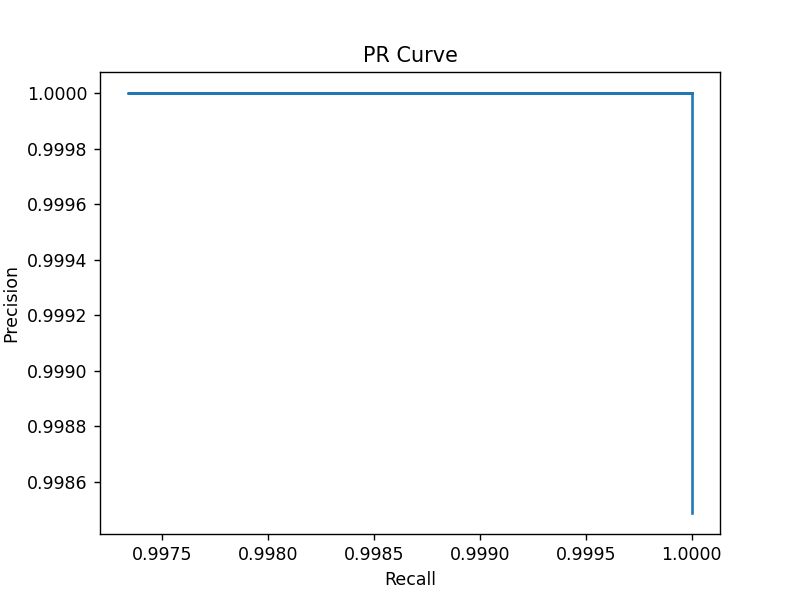

In [25]:
plt.plot(summ_model.recallByLabel,summ_model.precisionByLabel)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()

<IPython.core.display.Javascript object>


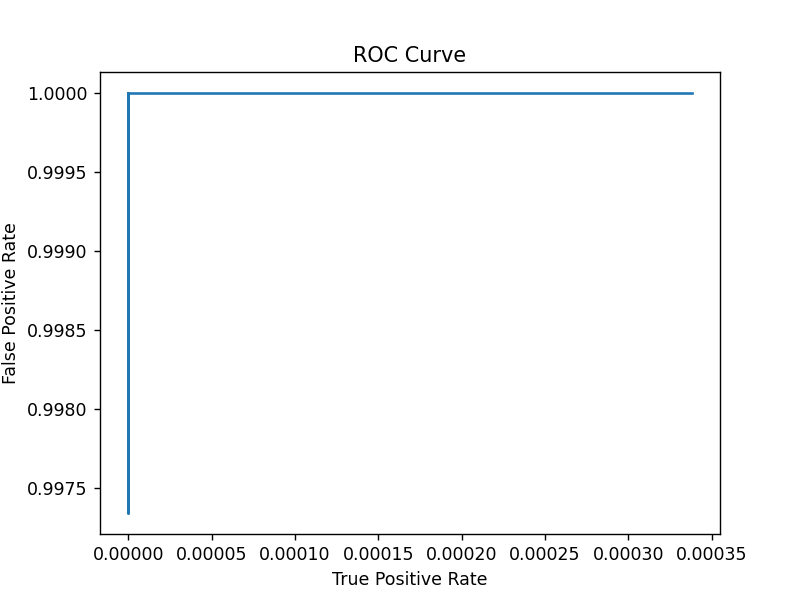

In [26]:
plt.plot(summ_model.falsePositiveRateByLabel,summ_model.truePositiveRateByLabel)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()